# Data Engineering - Exploring M&A corporate events

Once the data acquisition phase is complete and we have our initial feature space, the Data Exploration phase starts. This phase enables us to uncover insights from the data and/or identify areas or patterns to dive into and further explore. It allows for a deeper, more detailed, and better understanding of the data. This phase will also reveal any problems that the datasets might have, including dataset imbalance, multicolieanirity, missing values, outliers etc. After the problems with the dataset is identified the AI team can start devising strategies towards solving or smoothing them out.


This guide will walk through the exploration process of the M&A dataset we have aquired during the Data Ingestion phase in our article *+++*. To learn more about the business incentive and data aquisition process of the analysed dataset please visit the before-mentioned guide.

#### Import necessery modules and read the dataset

First, let's import the necessary modules that will help us explore and visualise statistical inferences in our dataset.

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.graph_objs.scatter.marker import Line
from scipy.stats import ttest_ind, ttest_ind_from_stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

#### Getting high-level information about the dataset

After reading the ingested datasets into a pandas dataframe we can request for general information on the structure of the frame using the info function. The function will give us basic statistics and meta information on non-null values per feature, dtype of the columns in memory as well as memory usage from the dataframe.

In [3]:
peer_data = pd.read_excel('Datasets/peer_data.xlsx',  index_col = 0)
target_data = pd.read_excel('Datasets/target_data.xlsx',  index_col = 0)

#add labels
target_data['Label'] = 1
peer_data['Label'] = 0

#merge the target and non-target datasets
dataset = pd.concat([target_data, peer_data], ignore_index = True,  axis = 0).reset_index(drop = True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3399 entries, 0 to 3398
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   instrument                    3399 non-null   object 
 1   AD-30                         3399 non-null   object 
 2   TR.TRBCIndustry               3394 non-null   object 
 3   TR.F.MktCap                   3155 non-null   float64
 4   TR.F.TotRevenue               3306 non-null   float64
 5   TR.F.ReturnAvgTotEqPctTTM     2896 non-null   float64
 6   TR.F.IncAftTaxMargPctTTM      3190 non-null   float64
 7   TR.F.GrossProfMarg            2912 non-null   float64
 8   TR.F.OpMargPctTTM             3201 non-null   float64
 9   TR.F.CurrRatio                2897 non-null   float64
 10  TR.F.ReturnCapEmployedPctTTM  3037 non-null   float64
 11  TR.F.WkgCaptoTotAssets        2895 non-null   float64
 12  TR.PriceToBVPerShare          3210 non-null   float64
 13  TR.

Alongside the dataset information, let's also explore the distribution of records between the two classes.

In [4]:
print(f"Number of target companies in training dataset is: {dataset.loc[dataset['Label']==1].shape[0]}")
print(f"Number of non-target companies in training dataset is: {dataset.loc[dataset['Label']==0].shape[0]}")

Number of target companies in training dataset is: 70
Number of non-target companies in training dataset is: 3329


From the dataset information we can see that there are 15 features, including the RIC, date indicating 30 days prior to announcement, industry, and 13 financal indicators. Most of our variables are numeric and only the industry is a categorical one. When it comes to the RIC and date features, these could be useful during the  feature engineering phase rather than being direct inputs of the AI model core. Next thing we observe is that the dataset is labeled for all datapoints. Also there is some mild to modest imbalancing, reflecting the fact that target companies are a small portion of the all companies. 

Another observation is that the features contain many null values and we don't have consistent number of non-null datapoints across features. Finally, we notice that some features are describing the same aspect of a company, i.e profitability (Income After Tax Margin, Profit Margin), leverage(Net Debt to Total Capita, Debt to EV), Leverage (Current Ratio, Working Capital to Total Assets). Although this is not necesserily a problem, it may cause multicolinearity issues and therefore bias our models during training. Further in this guide we conduct statistical analysis to identify such patterns.

Let's also observe the qualitative side of our features, particulary the distribution of the features, whether the financial data are relative or absolute valued features, statistical distributions etc. For that we use the **dataset.describe()** pandas command.

In [6]:
dataset.describe()

,TR.F.MktCap,TR.F.TotRevenue,TR.F.ReturnAvgTotEqPctTTM,TR.F.IncAftTaxMargPctTTM,TR.F.GrossProfMarg,TR.F.OpMargPctTTM,TR.F.CurrRatio,TR.F.ReturnCapEmployedPctTTM,TR.F.WkgCaptoTotAssets,TR.PriceToBVPerShare,TR.PriceToSalesPerShare,TR.EVToSales,TR.F.NetDebttoTotCap,TR.TotalDebtToEV,TR.F.NetDebtPerShr,Label
count,3.155000e+03,3.306000e+03,2896.000000,3.190000e+03,2912.000000,3.201000e+03,2897.000000,3037.000000,2895.000000,3210.000000,3181.000000,3186.000000,3171.000000,3168.000000,3.322000e+03,3399.000000
mean,2.423881e+11,1.260468e+11,3.820288,-2.156275e+04,48.717357,-2.126213e+04,2.576546,-6.055510,-0.223549,1.663084,141.863576,131.497293,0.152974,45.646483,6.637292e+04,0.020594
std,9.429384e+12,5.039583e+12,1235.950717,1.185785e+06,31.066515,1.172534e+06,4.706200,307.518511,8.332285,186.887847,3393.702728,3074.946635,1.872337,834.845612,2.430971e+06,0.142043
min,3.455871e+04,-2.032660e+08,-18622.014203,-6.695520e+07,-281.121910,-6.632350e+07,0.000000,-11813.241642,-374.137650,-5142.871746,0.000013,-24.453261,-8.570460,0.000000,-1.916999e+05,0.000000
25%,2.367030e+08,1.110292e+08,-8.573294,-1.130958e+01,27.461417,-5.304630e+00,0.962590,-2.518495,-0.005300,1.157542,1.201729,1.462738,-0.210450,3.979141,-1.010508e+00,0.000000
50%,1.738217e+09,5.416430e+08,7.202439,4.866122e+00,49.871230,8.912339e+00,1.529660,6.613059,0.108880,2.343023,3.302368,3.757784,0.156310,17.139102,1.074322e+00,0.000000
75%,9.027064e+09,2.156185e+09,16.258921,1.702795e+01,72.038625,2.386583e+01,2.524250,14.768785,0.303375,5.529784,7.675397,9.147852,0.438850,38.981862,1.131593e+01,0.000000
max,5.260235e+14,2.796048e+14,61400.000000,4.784759e+03,100.286150,3.973588e+02,81.714010,531.506339,0.986260,1358.614114,150933.975470,131223.218713,54.066340,45822.055448,1.168400e+08,1.000000


From the above descriptive dataframe we can observe that part of our features are relative measure of the company in the form of ratios (Gross Profit margin, Return on Equity etc) and many are absolute measures (Market Capitalization, Total Revenue). This can cause biasing issues if used as is. We therefore need to develop strategies that will reformat the data in a more consistent space. These strategies can include droping some of the features, feature engineering, normalization and more. 

We can also notice that the standard deviation is quite high for some of the features. For example, Gross Profit Margin has a standard deviation of 40 with values ranging from -281 to 100. This can be a result of outliers existence in our feature space. To understand more about the data we need to do a deep dive into the individual feature distributions.

#### Deep dive into individual feature distributions

In order to get more insight on the individual feature distributions we can generate plots that will allow us to draw some cocnlusions visually. Let's plot the distribution of gross profit margin to see if we can get more insights on that.

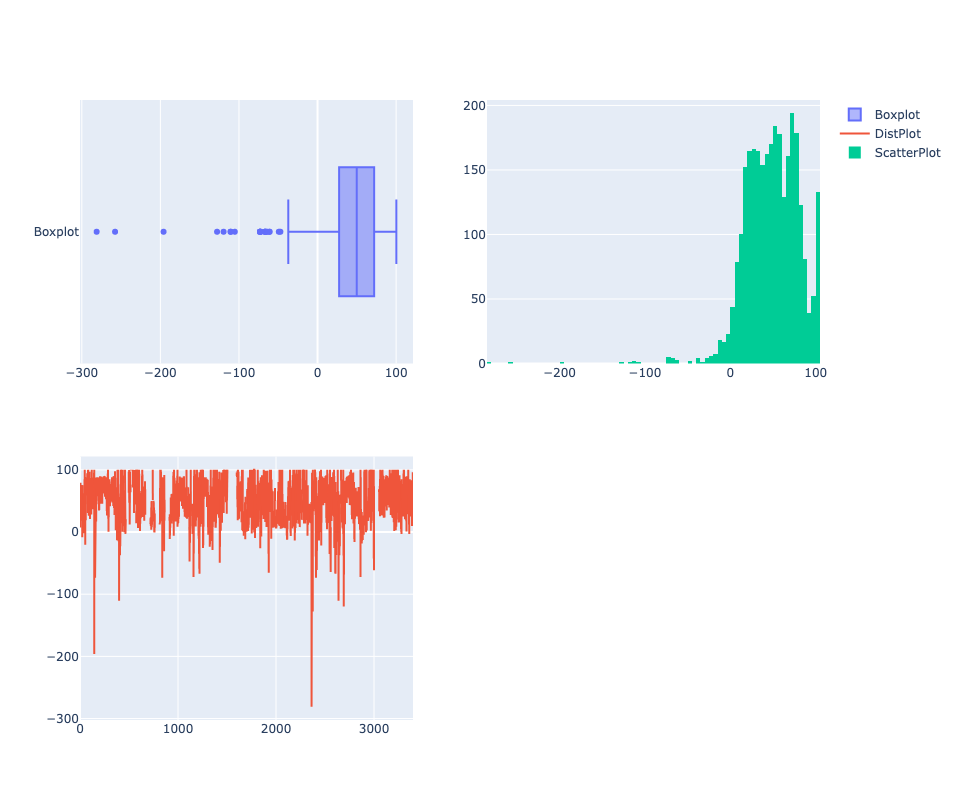

In [ ]:
fig = make_subplots(rows=2, cols=2)

fig.add_trace(go.Box( x = dataset["TR.F.GrossProfMarg"], name = 'Boxplot'), row=1, col=1)
fig.add_trace(go.Scatter( y = dataset["TR.F.GrossProfMarg"], name = 'DistPlot'), row=2, col=1)
fig.add_trace(go.Histogram( x = dataset["TR.F.GrossProfMarg"], name = 'ScatterPlot'), row=1, col=2)

fig.update_layout(height=800, width=1100)

The Boxplot is a very insightful visualisation that allows us to quickly identify outliers. If we consider datapoints which are 3 standard deviations (93) from the mean (46.68) as outliers, any observation outside - 47 to + 130 is an outlier. This is clearly visualized in the graph.

Another detail worth our attention about the Gross Profit Margin Distribition can be observed from the Histogram. There are several companies which have Gross Profit Margins larger than 100. This condradicts the nature of the formula calculating the ratio (Gross Profit Margin can be at maximum 100 if COGS is zero). This indicates the presence of noise in the data distribution which we need to address in the data preparation phase.

Another interesting visualisation is the scatterplot, in this case we notice that most of the companies in our feature space have positive margins.

In reality, during the Data Engineering phase of building AI models, we would want to do this exercise for all of the features, however, we will stop here as the purpose of this guide is just to showcase the major tools and workflows.

#### Make statistical inferences on the dataset

Amongst other statistical exploration tools that we can use, we need check our features against multicolinearity which can greatly bias regression models. We can do that by simply looking to a correlation matrix and also conduct a Variance Inflation Factor (VIF) analysis which is a measure of the amount of multicollinearity in a set of multiple regression variables.

Let's start by generating the correlation matrix. We calculate and show both Spearman and the Pearson correlations, where Spearman is measuring the monotonic relationship between the variables and Pearson identifies the linear relationship.

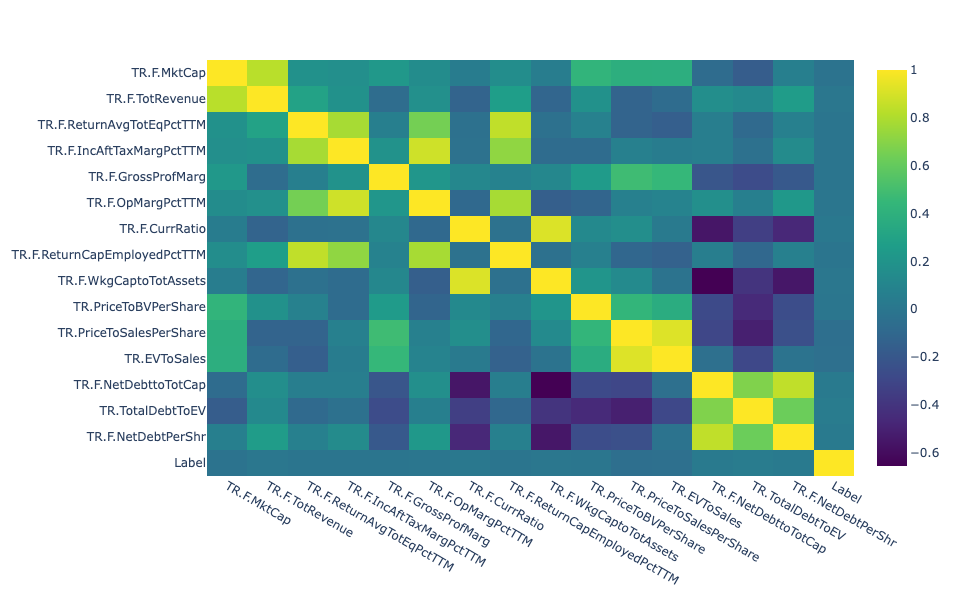

In [7]:
# get the subset of the dataset
dataset = dataset.iloc[:,3:19]

# calculate spearman correlation 
corr_spear = dataset.corr(method ='spearman')

fig = make_subplots(rows=2, cols=2)

fig = px.imshow(corr_spear,  aspect="auto", color_continuous_scale='viridis')
fig.update_layout(height=600, width=800)
fig.show()

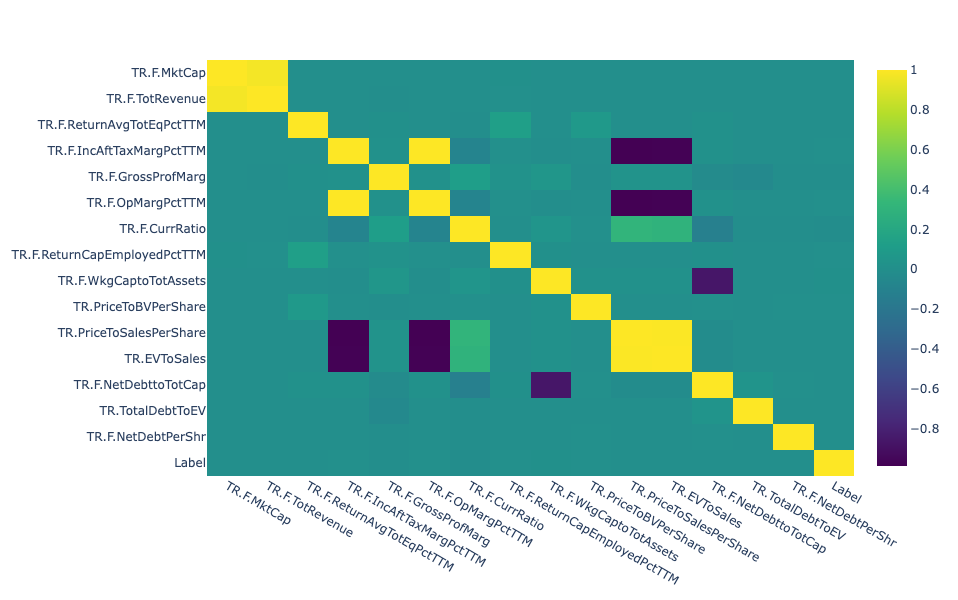

In [26]:
#calculate pearson correlation
corr_pears = dataset.corr(method ='pearson')

fig = px.imshow(corr_pears,  aspect="auto", color_continuous_scale='viridis')
fig.update_layout(height=600, width=800)
fig.show()

According to the correlation Heatmaps we can see quite a few features correlated with each other. For example, Market Capitalization is highly correlated with the Revenue measure, EV to Sales with Price to sales and more. Moreover, the Pearson correlation identifies stronger correlations suggesting high linear relationship.

The simplest approach to tackle the issue is to drop one of the correlated variables. The VIF test can help us determine which one to drop. The higher the VIF measure, the higher the variance that is captured by the variable. VIF values for other variables will decrease if we iteratively remove the variables with the highest VIF measures.

The code snippet below calculates and presents VIF scores for our features.

In [27]:
dataset.dropna(inplace = True)

# create dataframe to store VIF scores
vif_data = pd.DataFrame()
vif_data["feature"] = dataset.columns
vif_data

# calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(dataset.values, i)
                          for i in range(len(dataset.columns))] 

vif_data = vif_data.T
vif_data.rename(columns = vif_data.iloc[0], inplace = True)
vif_data = vif_data.iloc[1:]
vif_data

,TR.F.MktCap,TR.F.TotRevenue,TR.F.ReturnAvgTotEqPctTTM,TR.F.IncAftTaxMargPctTTM,TR.F.GrossProfMarg,TR.F.OpMargPctTTM,TR.F.CurrRatio,TR.F.ReturnCapEmployedPctTTM,TR.F.WkgCaptoTotAssets,TR.PriceToBVPerShare,TR.PriceToSalesPerShare,TR.EVToSales,TR.F.NetDebttoTotCap,TR.TotalDebtToEV,TR.F.NetDebtPerShr,Label
VIF,20.423804,20.244748,1.010539,327243.71349,0.555208,287531.927966,1.733408,1.039216,1.952898,1.010958,180299.129366,128944.631464,1.2642,0.839183,1.067391,0.999621


As mentioned above EV to Sales is highly correlated with Price to Sales and from the VIF results, we can see that the VIF on Price to Sales is higher than the one for EV to Sales, therefore the Price to Sales is a good candidate to be removed. However, if this would not be accepted as a solution, ,any feature engineering approaches can be used to eliminate the multicolinearity issue.

Another statistical inference that can be made from our dataset and which can be useful especialy for AI models addressing classification problems is the significance of the mean differences of features between two classes. That could indicate potential feature importances for our AI model. A T-test analysis is one of the best practices when it comes to making a statistical inference on mean differences between two datasets.

Below we calculate and report T-test measures (along with the statistical significance) for our feature space.

In [28]:
# run t-test
t_test = ttest_ind(dataset.loc[dataset['Label']==1], dataset.loc[dataset['Label']==0], equal_var = False)

#store results in a dataframe
ttest_data = pd.DataFrame()
ttest_data["feature"] = dataset.columns
ttest_data["t_test"] = t_test[0]
ttest_data["p-value"] = t_test[1]

ttest_data = ttest_data
ttest_data.rename(columns = ttest_data.iloc[0], inplace = True)
ttest_data = ttest_data.iloc[1:]
ttest_data

,TR.F.MktCap,-1.4047633293938333,0.16022674909774798
1,TR.F.TotRevenue,-1.401532,0.161190
2,TR.F.ReturnAvgTotEqPctTTM,0.053375,0.957454
3,TR.F.IncAftTaxMargPctTTM,1.013721,0.310822
4,TR.F.GrossProfMarg,-0.594129,0.554924
5,TR.F.OpMargPctTTM,1.015428,0.310008
6,TR.F.CurrRatio,-2.588226,0.011926
7,TR.F.ReturnCapEmployedPctTTM,-1.635066,0.107932
8,TR.F.WkgCaptoTotAssets,-0.589630,0.557894
9,TR.PriceToBVPerShare,0.326376,0.744171
10,TR.PriceToSalesPerShare,-1.077722,0.281271


The P-values of the t-test results, suggest that for almost all of the features there is no statisticaly significant mean difference between the two classes, with the exception of the Current ratio. Although we conducted a Welch’s t-test, which doesn't assume equal populations, absence of significant mean differences between our two populations (target and non-target) can be a result of dataset imbalancing. Particularly, our dataset consists of 70 target and 3329 non-target companies which can pose a challenge for the AI model cores and should be addressed before training and evaluation.

#### Conclusions

In this guide, we presented data exploration methodologies spanning many different levels of detail, from a high level overview of the dataset to detailed statistical inference on multicolinearities. We note here that, this initial statistical inference process is conducted on the uncleaned dataset and the landscape after dataset cleaning can be different. It is therefore suggested to do this step close to the data preparation phase as well to ensure correct feature selection.